# 第10章 TensorFlow高层封装

- 虽然原生态的TensorFlow API可以很灵活地支持不同的神经网络结构，但是其代码相对冗长，写起来比较麻烦；为了让用户更方便快捷地实现常用的神经网络结构，不同组织和个人为TensorFlow提供了多种高层封装
- 本章首先列举一些相对常用的高层API，并介绍它们各自的特点和共性，然后重点介绍使用最广的高层封装Keras和Google官方推荐的Estimator

## 10.1 TensorFlow高层封装总览

- 目前比较主流的TensorFlow高层封装主要有4个，分别是TensorFlow-Slim、TFLearn、Keras和Estimator
- TensorFlow-Slim是Google官方给出的相对较早的TensorFlow高层封装，Google通过TensorFlow-Slim开源了一些已经训练好的图像分析的模型，所以目前在图像识别问题中TensorFlow-Slim仍被较多地使用
- 与TensorFlow-Slim相比，TFLearn是一个更加简洁的TensorFlow高层封装；通过TFLearn可以更加容易地完成模型定义、模型训练以及模型评测的全过程；TFLearn没有集成在TensorFlow的安装包中，故需要单独安装

## 10.2 Keras介绍

- Keras是目前使用最为广泛的深度学习工具之一，它的底层可以支持TensorFlow、MXNet、CNTK和Theano；如今，Keras更是被直接引入了TensorFlow的核心代码库，成为TensorFlow官方提供的高层封装之一

## 10.2.1 Keras基本用法

- 和TFLearn API类似，Keras API也对模型定义、损失函数、训练过程等进行了封装，而且封装之后的整个训练过程和TFLearn是基本一致的，可以分为数据处理、模型定义和模型训练三个部分；使用原生态的Keras API需要先安装Keras包

- 以下代码展示了如何使用原生态Keras在MNIST数据集上实现LeNet-5模型

In [1]:
# coding: utf8
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras import backend as K

num_classes = 10
img_rows, img_cols = 28, 28

# 通过Keras封装好的API加载MNIST数据；其中trainX就是一个6000*28*28的数组，trainY是每一张图片对应的数字
(trainX, trainY), (testX, testY) = mnist.load_data()

# 因为不同的底层（TensorFlow或MXNet）对输入的要求不一样，所以这里需要根据对图像编码的格式要求来设置输入层的格式
if K.image_data_format() == "channels_first":
    trainX = trainX.reshape(trainX.shape[0], 1, img_rows, img_cols)
    testX = testX.reshape(testX.shape[0], 1, img_rows, img_cols)
    # 因为MNIST中的图片是黑白的，所以第一维的取值为1
    input_shape = (1, img_rows, img_cols)
else:
    trainX = trainX.reshape(trainX.shape[0], img_rows, img_cols, 1)
    testX = testX.reshape(testX.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# 将图像像素转化为0到1之间的实数
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255.0
testX /= 255.0

# 将标准答案转化为需要的格式（one-hot编码）
trainY = keras.utils.to_categorical(trainY, num_classes)
testY = keras.utils.to_categorical(testY, num_classes)

# 使用Keras API定义模型
model = Sequential()
# 一层深度为32，过滤器大小为5*5的卷积层
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
# 一层过滤器大小为2*2的最大池化层
model.add(MaxPooling2D(pool_size=(2, 2)))
# 一层深度为64，过滤器大小为5*5的卷积层
model.add(Conv2D(64, (5, 5), activation='relu'))
# 一层过滤器大小为2*2的最大池化层
model.add(MaxPooling2D(pool_size=(2, 2)))
# 将卷积层的输出拉直后作为下面全连接层的输入
model.add(Flatten())
# 全连接层，有500个节点
model.add(Dense(500, activation='relu'))
# 全连接层，得到最后的输出
model.add(Dense(num_classes, activation='softmax'))

# 定义损失函数、优化函数和评测方法
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(), metrics=['accuracy'])

# 类似TFLearn中的训练过程，给出训练数据、batch大小，训练轮数和验证数据，Keras可以自动完成模型训练过程
model.fit(trainX, trainY, batch_size=128, epochs=20, validation_data=(testX, testY))

# 在测试集数据上计算准确率
score = model.evaluate(testX, testY)
print "Test loss:", score[0]
print "Test accuracy:", score[1]

Using TensorFlow backend.


11501568/11490434 [==============================] - 5s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 58s 964us/step - loss: 1.0024 - acc: 0.7446 - val_loss: 0.3305 - val_acc: 0.9055
Epoch 2/20
60000/60000 [==============================] - 55s 917us/step - loss: 0.2850 - acc: 0.9141 - val_loss: 0.2317 - val_acc: 0.9286
Epoch 3/20
60000/60000 [==============================] - 59s 980us/step - loss: 0.1995 - acc: 0.9400 - val_loss: 0.1731 - val_acc: 0.9461
Epoch 4/20
60000/60000 [==============================] - 60s 1ms/step - loss: 0.1562 - acc: 0.9538 - val_loss: 0.1315 - val_acc: 0.9624
Epoch 5/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1289 - acc: 0.9615 - val_loss: 0.1076 - val_acc: 0.9680
Epoch 6/20
60000/60000 [==============================] - 63s 1ms/step - l

- 下面我们用Keras实现自然语言情感分类问题；使用循环神经网络判断语言的情感（比如在以下例子中需要判断一个评价是好评还是差评）和自然语言建模问题类似，唯一的区别在于除了最后一个时间点的输出是有意义的，其它时间点的输出都可以忽略
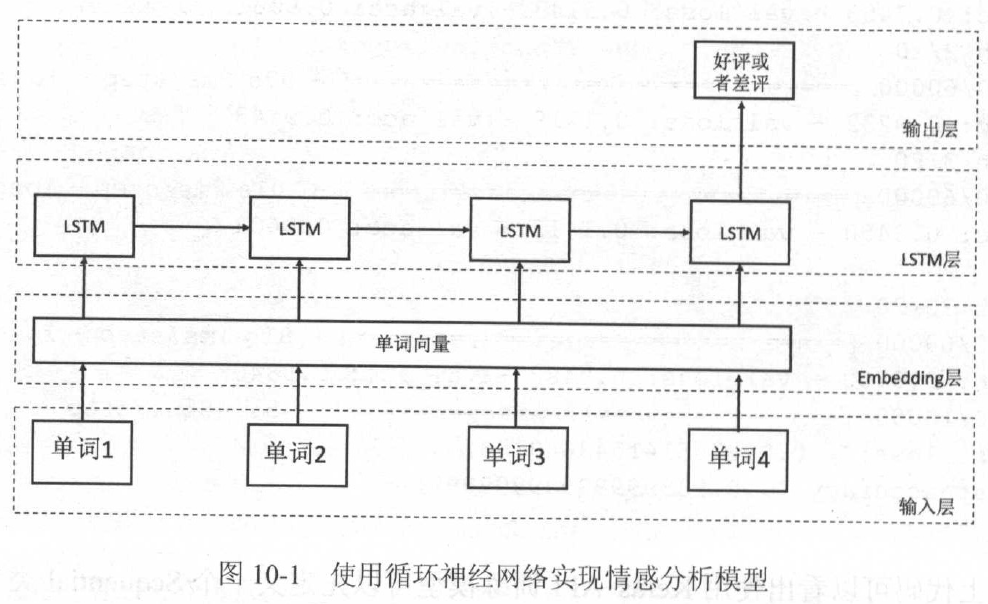

In [2]:
# coding: utf8
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

# 最多使用的单词数
max_features = 20000
# x循环神经网络的截断长度
maxlen = 80
batch_size = 32

# 加载数据并将单词转化为ID，max_features给出了最多使用的单词数；和自然语言模型类似，会将出现频率较低的单词替换为统一的ID；通过Keras封装的API会生成25000条训练数据和25000条测试数据，每一条数据可以被看成一段话，并且每段话都有一个好评或者差评的标签
(trainX, trainY), (testX, testY) = imdb.load_data(num_words=max_features)
print len(trainX), 'train sequences'
print len(testX), 'test sequences'

# 在自然语言中，每一段话的长度是不一样的，但循环神经网络的循环长度是固定的，所以这里需要先将所有段落统一成固定长度；对于长度不够的段落，要使用默认值0来填充，对于超过长度的段落则直接忽略掉超过的部分
trainX = sequence.pad_sequences(trainX, maxlen=maxlen)
testX = sequence.pad_sequences(testX, maxlen=maxlen)
print 'trainX shape:', trainX.shape
print 'testX shape:', testX.shape

# 在完成数据预处理之后构建模型
model = Sequential()
# 构建embedding层；128代表了embedding层的向量维度
model.add(Embedding(max_features, 128))
# 构建LSTM层
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# 构建最后的全连接层；注意在上面构建LSTM层时只会得到最后一个节点的输出，如果需要每个时间点的结果，那么可以将return_sequences参数设置为True
model.add(Dense(1, activation='sigmoid'))

# 与MNIST样例类似地指定损失函数、优化函数和评测指标
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# 与MNIST样例类似地指定训练数据、训练轮数、batch大小以及验证数据
model.fit(trainX, trainY, batch_size=batch_size, epochs=15, validation_data=(testX, testY))

# 在测试数据上评测模型
score = model.evaluate(testX, testY, batch_size=batch_size)
print "Test loss:", score[0]
print "Test accuracy:", score[1]

17473536/17464789 [==============================] - 15s 1us/step
25000 train sequences
25000 test sequences
trainX shape: (25000, 80)
testX shape: (25000, 80)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 144s 6ms/step - loss: 0.4612 - acc: 0.7834 - val_loss: 0.3713 - val_acc: 0.8359
Epoch 2/15
25000/25000 [==============================] - 141s 6ms/step - loss: 0.2989 - acc: 0.8800 - val_loss: 0.4114 - val_acc: 0.8317
Epoch 3/15
 6112/25000 [======>.......................] - ETA: 1:32 - loss: 0.1978 - acc: 0.9267

KeyboardInterrupt: 

### 10.2.2 Keras高级用法

- Sequential只支持顺序模型的定义，类似Inception这样的模型结构，通过Sequential类就不容易直接实现了；为了支持更加灵活的模型定义方法，Keras支持以返回值的形式定义网络层结构

In [3]:
# coding: utf8
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model

# 使用10.2.1小节中介绍的类似方法生成trainX、trainY、testX、testY，唯一不同是这里只用了全连接层，所以不需要将输入整理成三维矩阵
...

# 定义输入，这里指定的维度不用考虑batch大小
inputs = Input(shape=(784, ))
# 定义一层全连接层，该层有500个隐藏节点，使用ReLU激活函数；这一层的输入为inputs
x = Dense(500, activation='relu')(inputs)
# 定义输出层；注意因为Keras封装的categorical_crossentropy并没有将神经网络的输出再经过一层softmax，所以这里需要制定softmax作为激活函数
predictions = Dense(10, activation='softmax')(x)

# 通过Model类创建模型，和Sequential类不同的是Model类在初始化的时候需要指定模型的输入和输出
model = Model(inputs=inputs, outputs=predictions)

# 使用与10.2.1中类似的方法定义损失函数、优化函数和评测方法
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(), metrics=['accuracy'])
# 使用与10.2.1中类似的方法训练模型
model.fit(trainX, trainY, batch_size=128, epochs=20, validation_data=(testX, testY))

SyntaxError: invalid syntax (<ipython-input-3-eb633e548055>, line 8)

- 通过这样的方式，Keras就可以实现类似Inception这样的模型结构；以下代码展示了如何通过Keras实现Inception结构

In [5]:
from keras.layers import Conv2D, MaxPooling2D, Input

# 定义输入图像尺寸
input_img = Input(shape=(256, 256, 3))

# 定义第一个分支
tower_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

# 定义第二个分支；与顺序模型不同，第二个分支的输入使用的是input_img，而不是第一个分支的输出
tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

# 定义第三个分支；类似地，第三个分支的输入也是input_img
tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
tower_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(tower_3)

# 将三个分支通过concatenate的方式拼接在一起
output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

- 虽然通过返回值的方式已经可以实现大部分的神经网络模型，然而Keras API还存在两大问题；第一，原生态Keras API对训练数据的处理流程支持得不太好，基本上需要一次性将数据全部加载到内存，第二，原生态Keras API无法支持分布式训练；为了解决这两个问题，Keras提供了一种与原生态TensorFlow结合得更加紧密的方式，以下代码显示了如何将Keras和原生态TensorFlow API联合起来解决MNIST问题

In [6]:
# coding: utf8

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist_data=input_data.read_data_sets('/path/to/MNIST_data', one_hot=True)

# 通过TensorFlow中的placeholder定义输入；类似地，Keras封装的网络层结构也可以支持使用第7章中介绍的输入队列；这样可以有效避免一次性加载所有数据的问题
x = tf.placeholder(tf.float32, shape=(None, 784))
y_ = tf.placeholder(tf.float32, shape=(None, 10))

# 直接使用TensorFlow中提供的Keras API定义网络层结构
net = tf.keras.layers.Dense(500, activation='relu')(x)
y = tf.keras.layers.Dense(10, activation='softmax')(net)

# 定义损失函数和优化方法；注意这里可以混用Keras的API和原生态TensorFlow的API
loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_, y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

# 定义预测的正确率作为指标
acc_value = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(y_, y))

# 使用原生态TensorFlow的方式训练模型，这样可以有效地实现分布式
with tf.Session() as sess:
    tf.global_variable_initializer.run()
    
    for i in range(10000):
        xs, ys = mnist_data.train.next_batch(100)
        _, loss_value = sess.run([train_step, loss], feed_dict={x: xs, y_: ys})
        if i % 1000 == 0:
            print "After %d training step(s), loss on training batch is %g." % (i, loss_value)
            
    print acc_value.eval(feed_dict={x: mnist_data.test.images, y_: mnist_data.test.labels})

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.


PermissionDeniedError: /path; Permission denied

- 通过和原生态TensorFlow更紧密地结合，可以使建模的灵活性进一步提高，但是同时也会损失一部分封装带来的易用性，所以在实际问题中读者可根据需求合理地选择封装的程度

## 10.3 Estimator介绍

- 除了第三方提供的TensorFlow高层封装API，TensorFlow从1.3版本开始也推出了官方支持的高层封装tf.estimator，它能更好地整合原生态TensorFlow提供的功能

### 10.3.1 Estimator基本用法

- 类似其它的高层封装，本节先给出在MNIST数据集上，通过Estimator实现全连接神经网络的代码

In [7]:
# coding: utf8

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 将TensorFlow日志信息输出到屏幕
tf.logging.set_verbosity(tf.logging.INFO)
mnist = input_data.read_data_sets("/path/to/MNIST_data", one_hot=False)

# 指定神经网络的输入层；所有这里指定的输入都会拼接在一起作为整个神经网络的输入
feature_columns = [tf.feature_column.numeric_column("image", shape=[784])]

# 通过TensorFlow提供的封装好的Estimator定义神经网络模型；feature_columns参数给出了神经网络输入层需要用到的数据，hidden_units参数给出了神经网络的结构；注意这DNNClassifier只能定义多层全连接层神经网络，而hidden_units列表中给出了每一层隐藏层的节点个数；n_classes给出了总共类目的数量，optimizer给出了使用的优化函数；Estimator会将模型训练过程中的loss变化以及一些其他指标保存到model_dir目录下，通过TensorBoard可以可视化这些指标的变化过程
estimator = tf.estimator.DNNClassifier(feature_columns=feature_columns, hidden_units=[500], n_classes=10, 
                                       optimizer=tf.train.AdamOptimizer(), model_dir="/path/to/log")

# 定义数据输入；这里x中需要给出所有的输入数据，因为上面feature_columns只定义了一组输入，所以这里只需要指定一个就好，如果feature_columns中指定了多个，那么这里也需要多每一个指定的输入提供数据；y中需要提供每一个x对应的正确答案，这里要求分类的结果是一个正整数；num_epochs指定了数据循环使用的轮数；比如在测试时可以将这个参数指定为1；batch_size指定了一个batch的大小；shuffle指定了是否需要对数据进行随机打乱
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"image": mnist.train.images}, y=mnist.train.labels.astype(np.int32), num_epochs=None, batch_size=128, shuffle=True)

# 训练模型；注意这里没有指定损失函数，通过DNNClassifier定义的模型会使用交叉熵作为损失函数
estimator.train(input_fn=train_input_fn, steps=10000)

# 定义测试时的数据输入；指定的形式和训练时的数据输入基本一致
test_input_fn = tf.estimator.inputs.numpy_input_fn(x={"image": mnist.test.images}, y=mnist.test.labels.astype(np.int32), num_epochs=1, batch_size=128, shuffle=False)

# 通过evaluate评测训练好的模型的效果
accuracy_score = estimator.evaluate(input_fn=test_input_fn)["accuracy"]
print "\nTest accuracy: %g %%" % (accuracy_score*100)

PermissionDeniedError: /path; Permission denied

- 从以上代码可以看出，使用预先定义好的Estimator可以更加深层次地封装神经网络的定义和训练过程；在这个过程中，用户只需关注模型的输入以及模型的结构，其它的工作都可以通过Estimator自动完成；然而预先定义好的Estimator功能有限，比如目前无法很好地实现CNN或者RNN，也没有办法支持自定义的损失函数，所以为了更好地使用Estimator，下一小节将介绍如何使用Estimator自定义模型

### 10.3.2 Estimator自定义模型

- 若使用预先定义好的模型，除了不能灵活选择模型的结构，模型使用的损失函数和每一层使用的激活函数等也都是预先定义好的；为了更加灵活地构建模型，Estimator支持使用自定义的模型结构；以下代码展示了如何通过自定义的方式使用CNN解决MNIST问题

In [1]:
#coding utf8

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tf.logging.set_verbosity(tf.logging.INFO)

# 通过tf.layers来定义模型结构；这里可以使用原生态TensorFlow API或者任何TensorFlow的高层封装；X给出了输入层张量，is_training指明了是否为训练；该函数返回前向传播的结果
def lenet(x, is_training):
    # 将输入转化为卷积层需要的形状
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    net = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, 2, 2)
    net = tf.layers.conv2d(net, 64, 3, activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, 2, 2)
    net = tf.contrib.layers.flatten(net)
    net = tf.layers.dense(net, 1024)
    net = tf.layers.dropout(net, rate=0.4, training=is_training)
    return tf.layers.dense(net, 10)

# 自定义Estimator中使用的模型；定义的函数有4个输入，features给出了在输入函数中会提供的输入层张量；注意这是一个字典，字典里的内容是通过tf.estimator.inputs.numpy_input_fn中x参数的内容指定的；labels是正确答案，这个字段的内容是通过numpy_input_fn中y参数给出的；mode的取值有3种可能，分别对应Estimator类的train、evaluate和predict这3个函数；通过这个参数可以判断当前是否是训练过程；最后params是一个字典，这个字典中可以给出相关的任何超参数，比如这里将学习率放在params中
def model_fn(features, labels, mode, params):
    # 定义神经网络的结构并通过输入得到前向传播的结果
    predict = lenet(features["image"], mode==tf.estimator.ModeKeys.TRAIN)
    
    # 如果在预测模式，那么只需要将结果返回即可
    if mode == tf.estimator.ModeKeys.PREDICT:
        # 使用EstimatorSpec传递返回值，并通过predictions参数指定返回的结果
        return tf.estimator.EstimatorSpec(mode=mode, predictions={"result": tf.argmax(predict, 1)})
    
    # 定义损失函数
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=predict, label=labels))
    # 定义优化函数
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=params["learning_rate"])
    
    # 定义训练过程
    train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    
    # 定义评测标准，在运行evaluate时会计算这里定义的所有评测标准
    eval_metric_ops = {"my_metric": tf.metrics.accuracy(tf.argmax(predict, 1), labels)}
    
    # 返回模型训练过程需要使用的损失函数、训练过程和评测标准
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op, eval_metric_ops=eval_metric_ops)

mnist = input_data.read_data_sets("/path/to/MNIST_data", one_hot=False)

# 通过自定义的方式生成Estimator类；这里需要提供模型定义的函数并通过params参数指定模型定义时使用的超参数
model_params = {"learning_rate": 0.01}
estimator = tf.estimator.Estimator(model_fn=model_fn, params=model_params)

# 和10.3.1小节中类似，训练和评测模型
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"image": mnist.train.images}, y=mnist.train.labels.astype(np.int32), num_epochs=None, batch_size=128, shuffle=True)
estimator.train(input_fn=train_input_fn, steps=30000)
test_input_fn = tf.estimator.inputs.numpy_input_fn(x={"image": mnist.test.images}, y=mnist.test.labels.astype(np.int32), num_epochs=1, batch_size=128, shuffle=False)
test_results = estimator.evaluate(input_fn=test_input_fn)

# 这里使用的my_metric中的内容就是model_fn中eval_metric_ops定义的评测指标
accuracy_score = test_results["my_metric"]

# 使用训练好的模型在新数据上预测结果
predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"image": mnist.test.images[:10]}, num_epochs=1, shuffle=False)
predictions = estimator.predict(input_fn=predict_input_fn)
for i, p in enumerate(predictions):
    # 这里result就是tf.estimator.EstimatorSpec的参数predictions中指定的内容；
    # 因为这个内容是一个字典，所以Estimator可以很容易支持多输出
    print "Predictions %s: %s" % (i + 1, p["result"])

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.


PermissionDeniedError: /path; Permission denied

- 从以上代码可以看出，Estimator能非常好地支持自定义模型，而且模型结构的定义过程中也可以使用其它的TensorFlow高层封装（比如代码中使用到的tf.layers）；Estimator在支持自定义模型结构的同时，并不影响它对训练过程的封装